In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
img_size = 8
n_mid = 16
n_out = 10
eta = 0.001
epochs = 51
batch_size = 32
interval = 5

digits_data = datasets.load_digits()

print(digits_data.data.shape)
print(digits_data.target[:10])

(1797, 64)
[0 1 2 3 4 5 6 7 8 9]


**Layer**

In [3]:
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
class MiddleLayer(BaseLayer): # FC
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper) # He init
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x # input
        self.u = np.dot(x, self.w) + self.b # affine
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper) # Xavier
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u) / np.sum(np.exp(u), axis=1, keepdims=True) # softmax
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

**Preprocessing**

In [4]:
from sklearn.model_selection import train_test_split

input_data = np.asarray(digits_data.data)
input_data = (input_data - np.average(input_data)) / np.std(input_data) # normalization

correct = np.asarray(digits_data.target)
correct_data = np.zeros((len(correct), n_out))
for i in range(len(correct)):
    correct_data[i, correct[i]] = 1 # one-hot encoding
    
x_train, x_test, t_train, t_test = train_test_split(input_data, correct_data)

**forward and backward prop**

In [5]:
layers = [MiddleLayer(img_size * img_size, n_mid),
             MiddleLayer(n_mid, n_mid),
              OutputLayer(n_mid, n_out)
         ]

def forward_propagation(x):
    for layer in layers:
        layer.forward(x)
        x = layer.y
    return x

def backpropagation(t):
    grad_y = t
    for layer in reversed(layers):
        layer.backward(grad_y)
        grad_y = layer.grad_x
    return grad_y

def update_params():
    for layer in layers:
        layer.update(eta)

In [6]:
def get_error(x, t):
    y = forward_propagation(x)
    return - np.sum(t * np.log(y + 1e-7)) / len(y) # cross-entropy error

def get_accuracy(x, t):
    y = forward_propagation(x)
    count = np.sum(np.argmax(y, axis=1) == np.argmax(t, axis=1))
    return count / len(y)

**Mini-batch**

Epoch:1/51 Error_train: 1.9643372184331864 Error_test: 1.9866822450795396
Epoch:6/51 Error_train: 0.4582993551673209 Error_test: 0.4315023039192118
Epoch:11/51 Error_train: 0.22696163958389792 Error_test: 0.19983384825328973
Epoch:16/51 Error_train: 0.15309811276451585 Error_test: 0.14341337977633903
Epoch:21/51 Error_train: 0.11924224519881876 Error_test: 0.1138162399573939
Epoch:26/51 Error_train: 0.09792189211394647 Error_test: 0.09589975771170392
Epoch:31/51 Error_train: 0.07478072161786864 Error_test: 0.09105774814166741
Epoch:36/51 Error_train: 0.06426713951793694 Error_test: 0.08488621176311006
Epoch:41/51 Error_train: 0.053614200114614916 Error_test: 0.08519783362027308
Epoch:46/51 Error_train: 0.04956856676237977 Error_test: 0.09210790519308368
Epoch:51/51 Error_train: 0.03815829481118639 Error_test: 0.08222184755251533


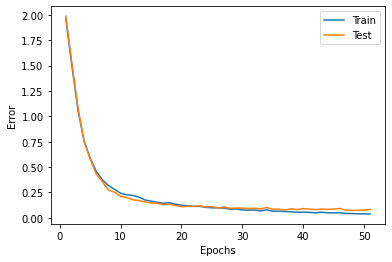

Acc_train: 99.55456570155901% Acc_test: 97.55555555555556%


In [7]:
error_record_train = []
error_record_test = []

n_batch = len(x_train) // batch_size
for i in range(epochs):
    
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)
    for j in range(n_batch):
        
        mb_index = index_random[j * batch_size:(j + 1) * batch_size]
        x_mb = x_train[mb_index, :]
        t_mb = t_train[mb_index, :]
        
        forward_propagation(x_mb)
        backpropagation(t_mb)
        
        update_params()
        
    error_train = get_error(x_train, t_train)
    error_record_train.append(error_train)
    error_test = get_error(x_test, t_test)
    error_record_test.append(error_test)
    
    if i % interval == 0:
        print("Epoch:" + str(i + 1) + "/" + str(epochs),
             "Error_train: " + str(error_train),
             "Error_test: " + str(error_test))
        
plt.plot(range(1, len(error_record_train) + 1), error_record_train, label="Train")
plt.plot(range(1, len(error_record_test) + 1), error_record_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

acc_train = get_accuracy(x_train, t_train)
acc_test = get_accuracy(x_test, t_test)
print("Acc_train: " + str(acc_train * 100) + "%",
     "Acc_test: " + str(acc_test * 100) + "%"
     )